## Setup

In [3]:
# import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import gsw
import sys

In [8]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

In [9]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

# fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

In [10]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

# fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

In [11]:
# define the Barents Sea up to the NZRU opening
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan

In [12]:
hfC = mygrid['hFacC']
hfC0 = hfC[0]

# Create a copy to modify
hfC_modified = hfC.copy()
hfC0_copy = np.full((ny, nx), np.nan)
hfC0_copy[np.isnan(hfC0)] = 1

# Modify only the copied version
hfC_modified[0] = hfC0_copy

## Define the timesteps and the gates

In [13]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2007,2008,1)

In [14]:
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

test = np.full(mskBasin.shape,np.nan)
test[y_bso,x_bso] = 1
test[y_sfj,x_sfj] = 2
test[y_fjnz,x_fjnz] = 3
test[y_nzru,x_nzru] = 4

(400.0, 600.0)

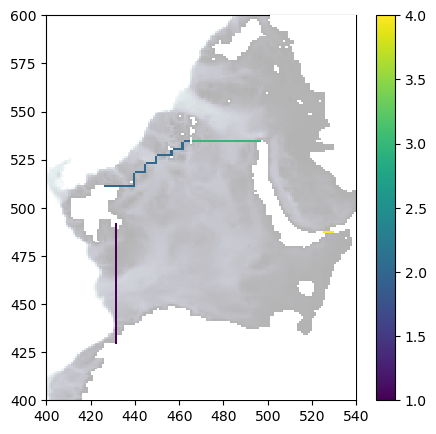

In [15]:
# get the four edges of this

# mask[mask>1]=1
xlims = np.array([400,540])
ylims = np.array([400,600])

# plot this
fig = plt.figure(figsize = (5,5))
plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="bone",alpha=0.3,vmin=0,vmax=1000)
plt.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="bone_r",zorder=5)
cb = plt.pcolormesh(get_aste_tracer(test,nfx,nfy)[0],zorder=10)
plt.colorbar(cb)
plt.xlim(xlims)
plt.ylim(ylims)

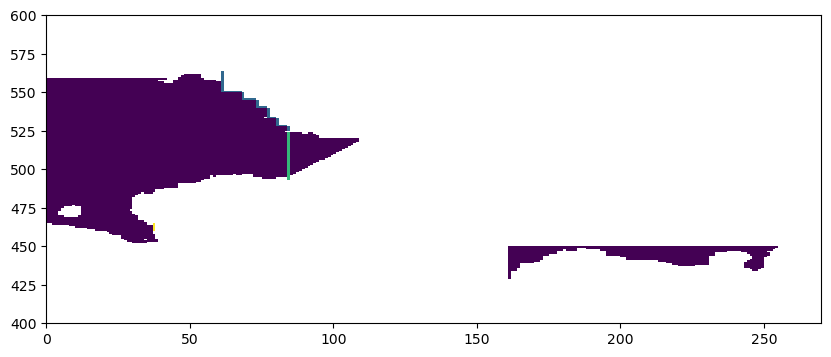

In [16]:
plt.pcolormesh(mymsk)
plt.ylim(400,600)
plt.pcolormesh(test)

## try to grab the adv terms

In [17]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

In [18]:
choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1
    
choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1

In [19]:
# Define dimensions
gate_labels = ["BSO", "SFJ", "FJNZ", "NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(test == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d, "NZRU": choose_UV_nzru3d}

# Initialize dictionary to store heat transport for each gate (without averaging)
num_years = len(allyears)  # Number of years
salt_transport_timeseries = {
    gate: np.full((num_years,12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}  # Shape: (12 months, depth, number of grid points per gate)

# Select a single year for processing
# year = allyears[4]  # Replace with the desired year
iy = 0
for year in allyears:
    print(f"Processing year: {year}")
    
    # Get time steps for this year
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)
    
    # Initialize arrays to hold full-year data (12 months)
    ADVx_SLT_all = np.full((12, nz, ny, nx), np.nan)
    ADVy_SLT_all = np.full((12, nz, ny, nx), np.nan)
    
    # Loop over all months (time steps)
    for i, ts in enumerate(tsstr):
        file_name = "budg3d_hflux_set2"
        meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + ts + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["ADVx_SLT", "ADVy_SLT"]]
    
        read = [int(ts)]
        ADVx_SLTi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[0])
        ADVy_SLTi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[1])
    
        ADVx_SLT_all[i] = np.reshape(ADVx_SLTi, (nz, ny, nx))
        ADVy_SLT_all[i] = np.reshape(ADVy_SLTi, (nz, ny, nx))
    
    # Store heat transport for each month without averaging
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use ADVx_SLT or ADVy_SLT
        
        for month in range(12):
            for depth in range(nz):
                advx_selected = ADVx_SLT_all[month, depth, y_idx, x_idx]  # No averaging
                advy_selected = ADVy_SLT_all[month, depth, y_idx, x_idx]  # No averaging
                
                # Use np.where() for per-gridpoint selection
                if gate == "BSO":
                    adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", advx_selected, -advy_selected)
                elif gate == "SFJ":
                    adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_selected, -advy_selected)
                else:
                    adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_selected, -advy_selected)
    
                salt_transport_timeseries[gate][iy,month, depth, :] = adv_selected  # Store per month
    
    print(f"Processed salt transport for {year}, with full monthly resolution.")
    iy += 1

Processing year: 2016
Processed salt transport for 2016, with full monthly resolution.


In [20]:
# data_to_save = {
#     "salt_transport_timeseries": salt_transport_timeseries
# }

# # Save to a .npy file
# np.save("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_advslt_2025_09.npy", data_to_save)

In [21]:
# Define dimensions
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(test == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d, "NZRU": choose_UV_fjnz3d}

# Initialize dictionary to store heat transport for each gate (without averaging)
heat_transport_timeseries = {
    gate: np.full((num_years,12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}  # Shape: (12 months, depth, number of grid points per gate)

# Select a single year for processing
# year = allyears[4]  # Replace with the desired year
iy = 0
for year in allyears:
    print(f"Processing year: {year}")
    
    # Get time steps for this year
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)
    
    # Initialize arrays to hold full-year data (12 months)
    ADVx_TH_all = np.full((12, nz, ny, nx), np.nan)
    ADVy_TH_all = np.full((12, nz, ny, nx), np.nan)
    
    # Loop over all months (time steps)
    for i, ts in enumerate(tsstr):
        file_name = "budg3d_hflux_set2"
        meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + ts + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["ADVx_TH", "ADVy_TH"]]
    
        read = [int(ts)]
        ADVx_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[0])
        ADVy_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[1])
    
        ADVx_TH_all[i] = np.reshape(ADVx_THi, (nz, ny, nx))
        ADVy_TH_all[i] = np.reshape(ADVy_THi, (nz, ny, nx))
    
    # Store heat transport for each month without averaging
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use ADVx_TH or ADVy_TH
        
        for month in range(12):
            for depth in range(nz):
                advx_selected = ADVx_TH_all[month, depth, y_idx, x_idx]  # No averaging
                advy_selected = ADVy_TH_all[month, depth, y_idx, x_idx]  # No averaging
                
                # Use np.where() for per-gridpoint selection
                if gate == "BSO":
                    adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", advx_selected, -advy_selected)
                elif gate == "SFJ":
                    adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_selected, -advy_selected)
                else:
                    adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_selected, -advy_selected)
    
                heat_transport_timeseries[gate][iy,month, depth, :] = adv_selected  # Store per month
    
    print(f"Processed heat transport for {year}, with full monthly resolution.")
    iy += 1

Processing year: 2016
Processed heat transport for 2016, with full monthly resolution.


In [22]:
# data_to_save = {
#     "heat_transport_timeseries": heat_transport_timeseries
# }

# # Save to a .npy file
# np.save("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_advheat_2025_09.npy", data_to_save)

In [23]:
# data_to_save for these are in units of degC.m^3/s and psu.m^3/s

## Just load some of these adv terms (ie one month) to see if we can do budget

In [24]:
layers_path = '/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/'

In [25]:
# we will use the bins from the An run so that we have the same thing in both sections
# Paths for the bins in this run
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1
print(nT)

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1
print(nS)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
print(binwidthT.shape)
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)

112
112
(112,)


In [26]:
# Define dimensions
num_years = len(allyears)  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ", "NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(test == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
binned_theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
binned_salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    binned_THETA_all = np.full((len(tsstr),nz,ny,nx),np.nan)
    binned_SALT_all = np.full((len(tsstr),nz,ny,nx),np.nan)

    # Loop over all time steps
    for i, ts in enumerate(tsstr):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + ts + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(ts)]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i] = np.reshape(SALTi, (nz, ny, nx))

        # bin these and also set in the gate
        binned_theta = bin_array(np.reshape(THETAi, (nz, ny, nx)),binsTH_edges)
        binned_theta = binned_theta.astype(float)
        binned_theta[binned_theta == nT] = np.nan      # I think this line is why we have previously had the mismatch between layers and avg
        binned_salinity = bin_array(np.reshape(SALTi, (nz, ny, nx)),binsSLT_edges)
        binned_salinity = binned_salinity.astype(float)
        binned_salinity[binned_salinity == nS] = np.nan
        binned_THETA_all[i] = binned_theta
        binned_SALT_all[i] = binned_salinity
  

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        theta_timeseries[gate][iy, :, :, :] = THETA_all[:, :, y_idx, x_idx]
        salt_timeseries[gate][iy, :, :, :] = SALT_all[:, :, y_idx, x_idx]
        binned_theta_timeseries[gate][iy, :, :, :] = binned_THETA_all[:, :, y_idx, x_idx]
        binned_salt_timeseries[gate][iy, :, :, :] = binned_SALT_all[:, :, y_idx, x_idx]

    iy += 1  # Move to the next year

Processing year: 2016


In [27]:
# Combine all dictionaries into one
data_to_save = {
    "heat_transport_timeseries": heat_transport_timeseries,
    "salt_transport_timeseries": salt_transport_timeseries,
    "theta_timeseries": theta_timeseries,
    "salt_timeseries": salt_timeseries,
    "binned_theta_timeseries": binned_theta_timeseries,
    "binned_salt_timeseries": binned_salt_timeseries
}

# Save to a .npy file
np.save("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2007.npy", data_to_save)



In [28]:
# To load later
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2007.npy", allow_pickle=True).item()

# Access the saved dictionaries
heat_transport_timeseries = loaded_data["heat_transport_timeseries"]
salt_transport_timeseries = loaded_data["salt_transport_timeseries"]
theta_timeseries = loaded_data["theta_timeseries"]
salt_timeseries = loaded_data["salt_timeseries"]
binned_theta_timeseries = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries = loaded_data["binned_salt_timeseries"]

## get the overall transport

In [17]:
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.array([3,4])
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

tsteps = len(datetimes)-1
tsteps

{'2007': array([3, 4])}


1

In [18]:
# set a larger array for one year of the terms
nS,nT = 112,112
vol_mesh_all = np.zeros((tsteps,nS,nT))
JtermsT_all = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all = np.zeros((tsteps,5,nS,nT))

In [19]:
vol = np.tile(mygrid['DXG'][np.newaxis,:,:],(50,1,1)) * np.tile(mygrid['DYG'][np.newaxis,:,:],(50,1,1)) * DRF3d
dstart = 0
dterm = 50  # for upper 100 m
for i in range(len(datetimes)-1):
    print(datetimes[i])
    tsstrhere = tsstr[i:i+2]
    datetimeshere = datetimes[i:i+2]
    dt = datetimes[i+1]-datetimes[i]
    dt = dt.total_seconds()
    t2 = int(tsstr[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn,bT,bS = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,mymsk,6,RAC,RAC3,myparms,dstart,dterm)

    vol_mesh_all[i] = vol_mesh
    JtermsT_all[i] = JtermsT
    JtermsS_all[i] = JtermsS
    JtermsT_nn_all[i] = JtermsT_nn
    JtermsS_nn_all[i] = JtermsS_nn

2007-03-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -8.222985291958524e-12 Sv/PSU
doing JtermsS
total residual -0.15816064499149815 Sv/degC
doing not normalized J terms
total residual -8.222985291958524e-12 Sv
total residual -0.15816064499149815 Sv


## Let's try to recreate eq. 20 of the Hieronymus 2014 paper

$$
\frac{\partial v}{\partial t} = -\nabla \textbf{J} - \frac{\partial ^2 M}{\partial T \partial S} - \frac{\partial ^2 E}{\partial T \partial S} 
$$

Notes on the above:
    - dv/dt is from the snaps :  etan
    - nabla J is from avg of internal transformation (DF and KPP from calculating J terms, not sure about this)
    - M is volume transport into the bins as an avg from ADV (heat_transport_timeseries)
    - E is the surface term (avg)

For M, 

In [20]:
# get the advective terms from the heat_transport_timeseries and salt_transport_timeseries at the gate

heat_transport_timeseries.keys()  # we don't have to do any heat conversion given this is already in units of temperature/salinity
salt_transport_timeseries.keys()

dict_keys(['BSO', 'SFJ', 'FJNZ', 'NZRU'])

In [21]:
# load the bins
# we will use the bins from the An run so that we have the same thing in both sections
# Paths for the bins in this run
copypath = "/scratch/mmurakami/ASTE_270/LAYERS_copies/"
filename = "layers2TH"
boundsT = rdmds(copypath + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1
# boundsT

filename = "layers1SLT"
boundsS = rdmds(copypath + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1
# boundsS

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)
nS,nT = 112,112

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)

In [22]:
# Bin metadata
binsT_edges = binsTH_edges            # len = nT+1
binsS_edges = binsSLT_edges           # len = nS+1
binwidthT   = binsT_edges[1:] - binsT_edges[:-1]   # (nT,)
binwidthS   = binsS_edges[1:] - binsS_edges[:-1]   # (nS,)
Tcent       = 0.5 * (binsT_edges[1:] + binsT_edges[:-1])  # (nT,)
Scent       = 0.5 * (binsS_edges[1:] + binsS_edges[:-1])  # (nS,)


In [23]:
import numpy as np

def m_TS_from_prebinned(heat_tr, salt_tr, iT, iS, Tcent, Scent, binwidthT, binwidthS,
                        T_min=1e-3, S_min=1e-4):
    """
    Inputs:
      heat_tr : (nz, nfaces)  degC·m^3/s  (T*Q)
      salt_tr : (nz, nfaces)  psu·m^3/s   (S*Q)
      iT, iS  : (nz, nfaces)  integer bin indices in [0..nT-1],[0..nS-1]
      Tcent   : (nT,)         bin centers (degC)
      Scent   : (nS,)         bin centers (psu)
    Output:
      m_TS    : (nS, nT)      Sv/(psu·°C)
    """
    nT = len(Tcent); nS = len(Scent)
    m_TS = np.zeros((nS, nT), dtype=float)

    # Flatten
    HT  = heat_tr.reshape(-1)              # degC·m^3/s
    ST  = salt_tr.reshape(-1)              # psu·m^3/s
    iTf = iT.reshape(-1).astype(int)
    iSf = iS.reshape(-1).astype(int)

    # Valid bins
    valid = (iTf >= 0) & (iTf < nT) & (iSf >= 0) & (iSf < nS)
    if not np.any(valid):
        return m_TS

    iTv = iTf[valid]; iSv = iSf[valid]
    HTv = HT[valid];  STv = ST[valid]

    # Get bin-center T,S for those indices
    Tv = Tcent[iTv]; Sv = Scent[iSv]

    # Recover Q (m^3/s). Prefer salt (often better conditioned), fallback to heat.
    Qs = np.where(np.abs(Sv) > S_min, STv / Sv, np.nan)
    Qt = np.where(np.abs(Tv) > T_min, HTv / Tv, np.nan)
    Q  = np.where(np.isfinite(Qs), Qs, Qt)
    Q  = np.where(np.isfinite(Q), Q, 0.0)   # m^3/s (+ into basin)

    # Convert to Sv and normalize by ΔS·ΔT → Sv/(psu·°C)
    dSv = binwidthS[iSv]; dTv = binwidthT[iTv]
    contrib = (Q * 1e-6) / (dSv * dTv)

    np.add.at(m_TS, (iSv, iTv), contrib)
    return m_TS


In [24]:
year_idx  = 4    # example
month_idx = 2    # example
gates = ["BSO", "SFJ", "FJNZ"]

m_by_gate = {}
Jx_by_gate = {}
Jy_by_gate = {}

for g in gates:
    # property transports (T*Q, S*Q) and *pre-binned indices* (ints)
    HT = heat_transport_timeseries[g][year_idx, month_idx]           # (nz, nfaces)
    ST = salt_transport_timeseries[g][year_idx, month_idx]           # (nz, nfaces)
    iT = binned_theta_timeseries[g][year_idx, month_idx]             # (nz, nfaces) ints
    iS = binned_salt_timeseries[g][year_idx, month_idx]              # (nz, nfaces) ints

    m_gate = m_TS_from_prebinned(HT, ST, iT, iS, Tcent, Scent, binwidthT, binwidthS)
    m_by_gate[g] = m_gate                                            # Sv/(psu·°C)

    # Diagnostic J (Convention A): Jx = ∫ m dS, Jy = 0
    Jx = np.cumsum(m_gate * binwidthS[:, None], axis=0)              # Sv/°C
    Jy = np.zeros_like(Jx)                                           # Sv/psu
    Jx_by_gate[g], Jy_by_gate[g] = Jx, Jy

# Total gate term for the budget:
m_TS_total = sum(m_by_gate[g] for g in gates)                        # Sv/(psu·°C)


/tmp/ipykernel_1836165/2410716784.py:37: RuntimeWarning: divide by zero encountered in divide
  Qt = np.where(np.abs(Tv) > T_min, HTv / Tv, np.nan)
/tmp/ipykernel_1836165/2410716784.py:37: RuntimeWarning: invalid value encountered in divide
  Qt = np.where(np.abs(Tv) > T_min, HTv / Tv, np.nan)


In [25]:
def compute_gradient_manual(data_s, data_t, spacing_s, spacing_t):
    # Gradient for salinity along axis 0
    gradient_s = np.zeros_like(data_s)
    gradient_s[1:-1] = (data_s[2:] - data_s[:-2]) / (spacing_s[2:] + spacing_s[:-2])
    gradient_s[0] = (data_s[1] - data_s[0]) / spacing_s[1]  # forward difference at start
    gradient_s[-1] = (data_s[-1] - data_s[-2]) / spacing_s[-1]  # backward difference at end

    # Gradient for temperature along axis 1
    gradient_t = np.zeros_like(data_t)
    gradient_t[:, 1:-1] = (data_t[:, 2:] - data_t[:, :-2]) / (spacing_t[:, 2:] + spacing_t[:, :-2])
    gradient_t[:, 0] = (data_t[:, 1] - data_t[:, 0]) / spacing_t[:, 1]  # forward difference at start
    gradient_t[:, -1] = (data_t[:, -1] - data_t[:, -2]) / spacing_t[:, -1]  # backward difference at end

    return gradient_s, gradient_t

In [26]:
binwidthTtile = np.tile(binwidthT[np.newaxis,:],(nS,1))
binwidthStile = np.tile(binwidthT[:,np.newaxis],(1,nT))

In [28]:
binwidthTtile.shape

(112, 112)

In [29]:
binwidthStile.shape

(112, 112)

In [27]:
JtermsS_all[0][1].shape

(112, 112)

In [34]:
J_S_div, J_T_div = compute_gradient_manual(JtermsS_all[0][1], JtermsT_all[0][1], binwidthStile, binwidthTtile)
div_J = J_S_div + J_T_div
div_J[JtermsS_all[0][0] == 0] = 0

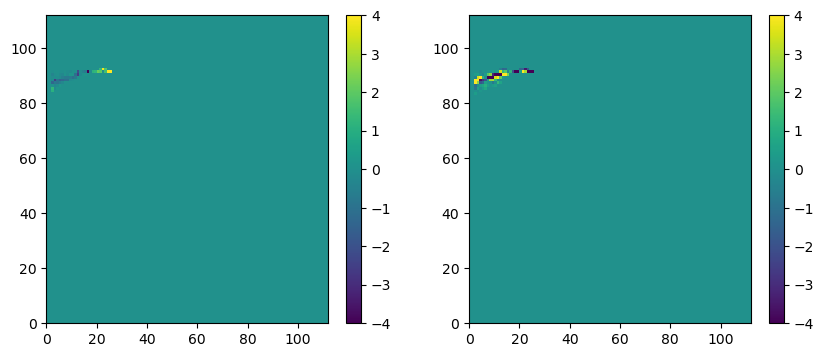

In [46]:
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(m_TS_total,vmin=-4,vmax=4)
plt.colorbar(cb)

ax = plt.subplot(122)
cb = ax.pcolormesh(div_J-m_TS_total,vmin=-4,vmax=4)
plt.colorbar(cb)

## try to represent this as an example budget of so we can tell (may need to skip NZ_RU gate for now)

In [61]:
# overall tendency
J_S_div, J_T_div = compute_gradient_manual(JtermsS_all[0][0], JtermsT_all[0][0], binwidthStile, binwidthTtile)
div_J = J_S_div + J_T_div
div_J[JtermsS_all[0][0] == 0] = 0

# surface tendency
J_S_div, J_T_div = compute_gradient_manual(JtermsS_all[0][3], JtermsT_all[0][3], binwidthStile, binwidthTtile)
div_Js = J_S_div + J_T_div
div_Js[JtermsS_all[0][3] == 0] = 0

# internal mixing
J_S_div, J_T_div = compute_gradient_manual(JtermsS_all[0][2]+JtermsS_all[0][4], JtermsT_all[0][2]+JtermsT_all[0][4], binwidthStile, binwidthTtile)
div_Ji = J_S_div + J_T_div
div_Ji[JtermsS_all[0][2] == 0] = 0

# advection
J_S_div, J_T_div = compute_gradient_manual(JtermsS_all[0][1], JtermsT_all[0][1], binwidthStile, binwidthTtile)
div_Ja = J_S_div + J_T_div
div_Ja[JtermsS_all[0][1] == 0] = 0

(-2.0, 9.0)

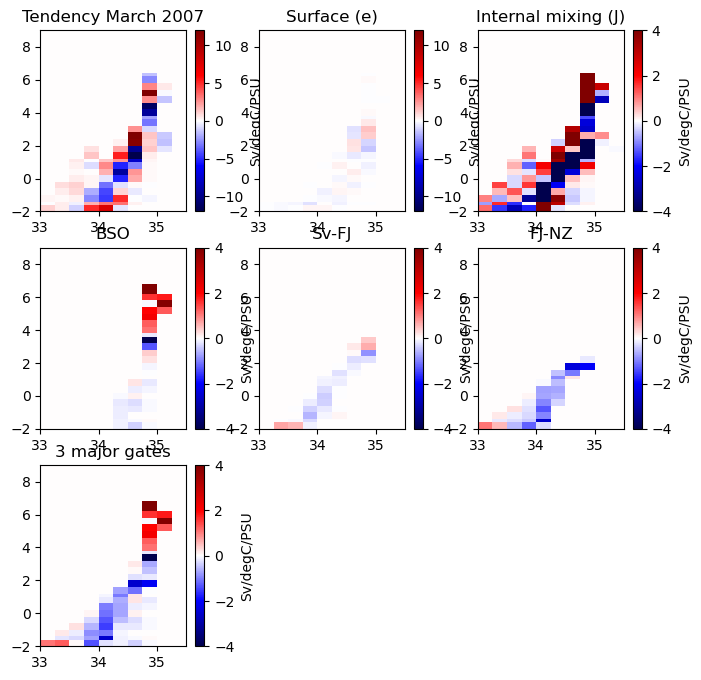

In [59]:
fig = plt.figure(figsize = (8,8))
ax = plt.subplot(331)
cb = ax.pcolormesh(Sbin,Tbin,(div_J),cmap="seismic",vmin=-12,vmax=12)
ax.set_title("Tendency March 2007")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(332)
cb = ax.pcolormesh(Sbin,Tbin,(div_Js),cmap="seismic",vmin=-12,vmax=12)
ax.set_title("Surface (e)")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(333)
cb = ax.pcolormesh(Sbin,Tbin,(div_Ji),cmap="seismic",vmin=-4,vmax=4)
ax.set_title("Internal mixing (J)")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(334)
cb = ax.pcolormesh(Sbin,Tbin,(m_by_gate['BSO']),cmap="seismic",vmin=-4,vmax=4)
ax.set_title("BSO")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)


ax = plt.subplot(335)
cb = ax.pcolormesh(Sbin,Tbin,(m_by_gate['SFJ']),cmap="seismic",vmin=-4,vmax=4)
ax.set_title("Sv-FJ")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(336)
cb = ax.pcolormesh(Sbin,Tbin,(m_by_gate['FJNZ']),cmap="seismic",vmin=-4,vmax=4)
ax.set_title("FJ-NZ")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(337)
cb = ax.pcolormesh(Sbin,Tbin,(m_TS_total),cmap="seismic",vmin=-4,vmax=4)
ax.set_title("3 major gates")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)


(-2.0, 9.0)

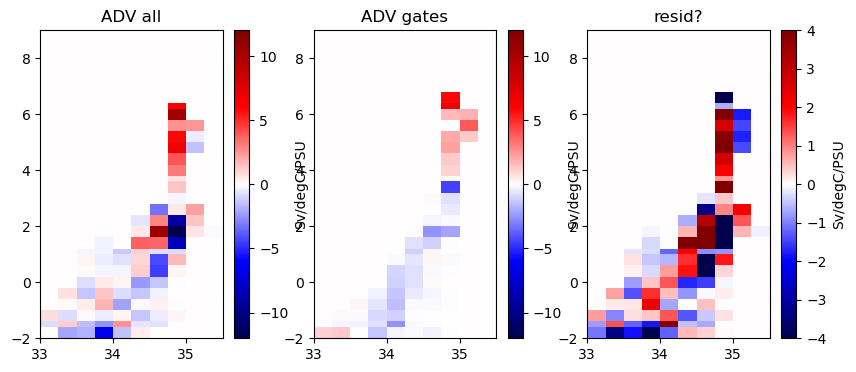

In [66]:
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(Sbin,Tbin,(-div_Ja),cmap="seismic",vmin=-12,vmax=12)
ax.set_title("ADV all")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(132)
cb = ax.pcolormesh(Sbin,Tbin,(m_TS_total),cmap="seismic",vmin=-12,vmax=12)
ax.set_title("ADV gates")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(133)
t = -div_Ja - m_TS_total
cb = ax.pcolormesh(Sbin,Tbin,(-div_Ja - m_TS_total),cmap="seismic",vmin=-4,vmax=4)
ax.set_title("resid?")
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)